In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [4]:
import MiniTools as mini
import MicroTools as micro
import param_scan

In [5]:
print(mini.bin_edges_reco)
print(micro.bin_edges_reco)

[0.2   0.3   0.375 0.475 0.55  0.675 0.8   0.95  1.1   1.3   1.5   3.   ]
[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0]


In [6]:
param_scan.Weight.sum()/len(param_scan.Weight)

208945.81184273175

ValueError: x and y must have same first dimension, but have shapes (11,) and (5,)

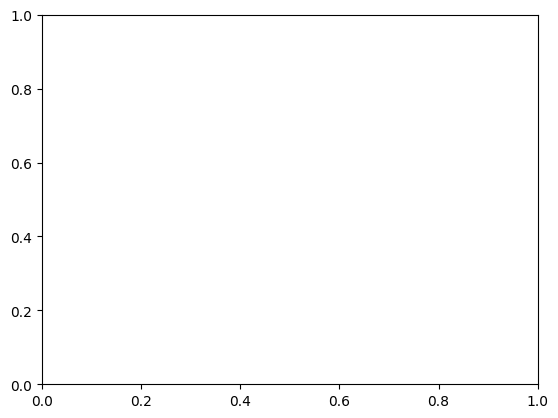

In [7]:
# %%prun
data = param_scan.DecayReturnMicroBooNEChi2([100, 1])
plt.plot(param_scan.MB_Ereco_official_bins[:-1], data)#/np.diff(param_scan.MB_Ereco_official_bins)/1e3)

In [ ]:
import copy
# Load the MiniBooNE MC from data release
MiniBooNE_Signal = micro.mb_mc_data_release
MB_Ereco_Bins = micro.bin_edges_reco
LMBT = 0.4685  # Baseline length in kilometers
Ereco = MiniBooNE_Signal[:, 0] / 1000  # GeV
Etrue = MiniBooNE_Signal[:, 1] / 1000  # GeV
Length = MiniBooNE_Signal[:, 2] / 100000  # Kilometers
# Reweighted by a factor of 1/24860 to match Pedro's signal rate
Weight = MiniBooNE_Signal[:, 3]

# Set up a migration matrix that maps Etrue to Ereco with shape of (50,13)
e_prod_e_int_bins = np.linspace(0, 3, 51)
h0_unnorm = np.histogram2d(
    Etrue, Ereco, bins=[e_prod_e_int_bins, MB_Ereco_Bins], weights=Weight
)[0]
migration_matrix = copy.deepcopy(h0_unnorm)

gm4, Um4Sq = 1, 1e-3
sterile = param_scan.Sterile(gm4, 0, Um4Sq)
# Flavor transition probabilities -- Assuming nu4 decays only into nue
Pme = Um4Sq * sterile.Pdecay(Etrue, Length)
Pmm = 1 - Um4Sq * sterile.Pdecay(Etrue, Length)

Etrue_ext, Etrue_int, Weight_int = param_scan.create_Etrue_and_Weight_int()

Weight_int = Weight_int

# # Calculate the MiniBooNE chi2
# MBSig_for_MBfit = np.dot(
#     (np.histogram(Etrue_int, bins=e_prod_e_int_bins, weights=Weight_int)[0]),
#     param_scan.migration_matrix_official_bins,
# )

# MB_chi2 = mini.fit.chi2_MiniBooNE_2020(MBSig_for_MBfit)


In [ ]:
param_scan.Length

array([0.518847  , 0.50860715, 0.5332256 , ..., 0.50574088, 0.53443652,
       0.51996619])

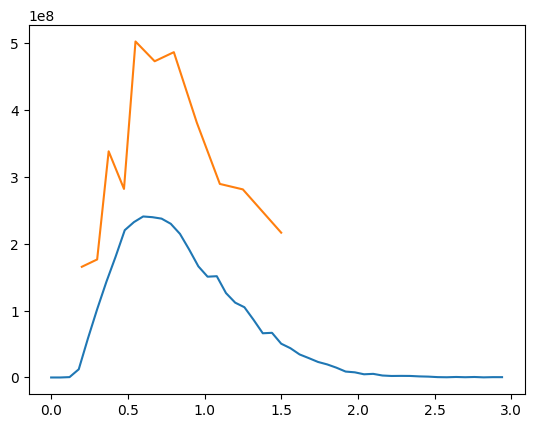

In [ ]:
plt.plot(e_prod_e_int_bins[:-1], np.histogram(param_scan.Etrue, bins=e_prod_e_int_bins, weights=param_scan.Weight)[0])
plt.plot(param_scan.MB_Ereco_official_bins[:-1], np.dot(np.histogram(param_scan.Etrue, bins=e_prod_e_int_bins, weights=param_scan.Weight)[0], param_scan.migration_matrix_official_bins))

In [8]:
from MicroTools.InclusiveTools.inclusive_osc_tools import DecayMuBNuMuDis
gm4, Um4Sq = 1, 1e-3
DecayMuBNuMuDis(gm4, Um4Sq)

[[1.0878221673318857,
  10.20956028402181,
  782.2838563722214,
  2261.3228049471054,
  3473.3163858507337,
  4094.053668745482,
  4376.158896109556,
  4099.522727015532,
  3481.8193756961246,
  2781.960499075674,
  2132.171381539117,
  1642.7412239626196,
  1124.408928074895,
  740.2979202967454,
  518.432096778758,
  374.87948974884523,
  219.56043916496031,
  137.5945352250522,
  114.35106873735992,
  72.16552436785801,
  40.44902092231546,
  23.273406563307294,
  16.16763234183862,
  14.89018979497081,
  7.3752347561018725,
  34.19154843915697],
 [9.560859090429402,
  169.6303986293983,
  2269.735971312234,
  5788.461459310346,
  8849.313615811183,
  10112.115483541384,
  9874.002191989728,
  8861.808612408502,
  7286.841706647117,
  5769.409614712997,
  4409.581997134867,
  3105.2133498045355,
  2245.6941113226385,
  1598.4598772065126,
  1040.5069013169389,
  780.5972415250163,
  550.4280411641789,
  390.80760186113963,
  288.0433362876673,
  204.1912085564645,
  158.602477342844

In [35]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 30

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4, 1, Npoints)

# Range of gm4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(x_Vec, y_Vec)).T.reshape(-1, 2)

In [36]:
# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2, paramlist_decay)
np.save(f"{path_results}/App_gm4_Um4sq_migrated_1_v2", res)